卷积神经网络利用卷积核的方式来共享参数，使得参数量大大降低的同时还可以利用空间信息，但是对有先后顺序有关的数据就没多大优势

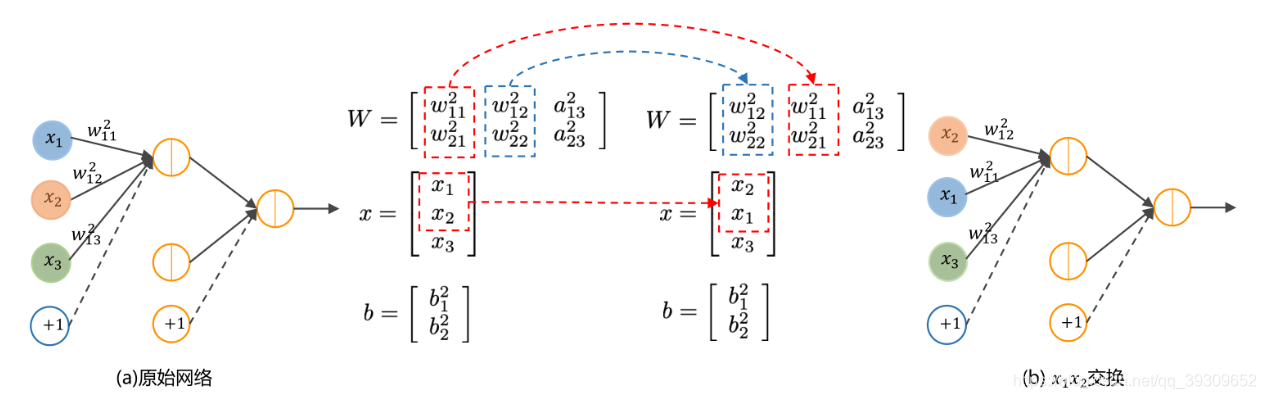

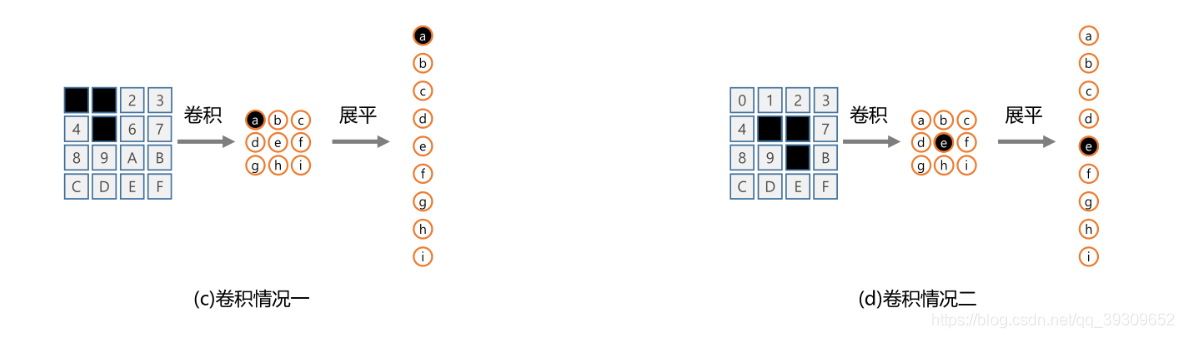

当改变位置信息后还是原来的数据，不会有变换，就比如一句话，我喜欢你，你喜欢我，虽然一样多的词的，但是表达意思就是不一样，所以产生RN

# 时间序列

是指将同一统计指标的数值按其发生的时间先后顺序排列而成的数列。时间序列分析的主要目的是根据已有的历史数据对未来进行预测。

在时间序列问题上，观察值具有时间先后的特征，历史数据可以影响未来数据的表达，因此需要网
络具有记忆能力

最开始有自回归模型，将所有数据的前面数据全部拿到，但是参数过多且运算麻烦，

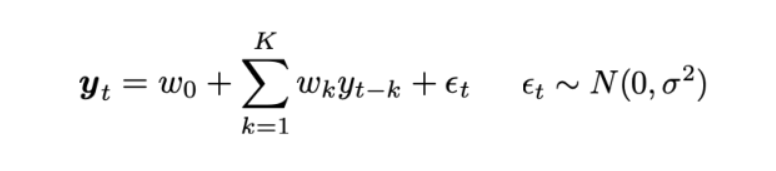

之后产生 N-gram 语言模型：使用固定宽度的窗口

[外链图片转存失败,源站可能有防盗链机制,建议将图片保存下来直接上传(img-Yni789FS-1619622800219)(attachment:image.png)]

缺点：受限于窗口的宽度，N并不能取很大的值，会出现长期依赖缺失的问题。

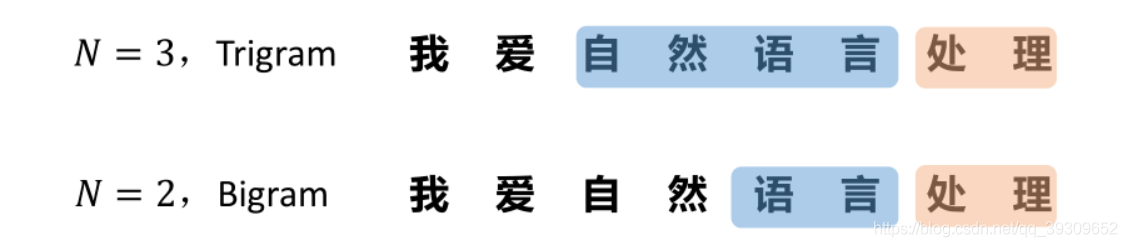

一般我们会通过他在法国，推测出他学会说法语，但是时间跨度太大，数据容易丢失

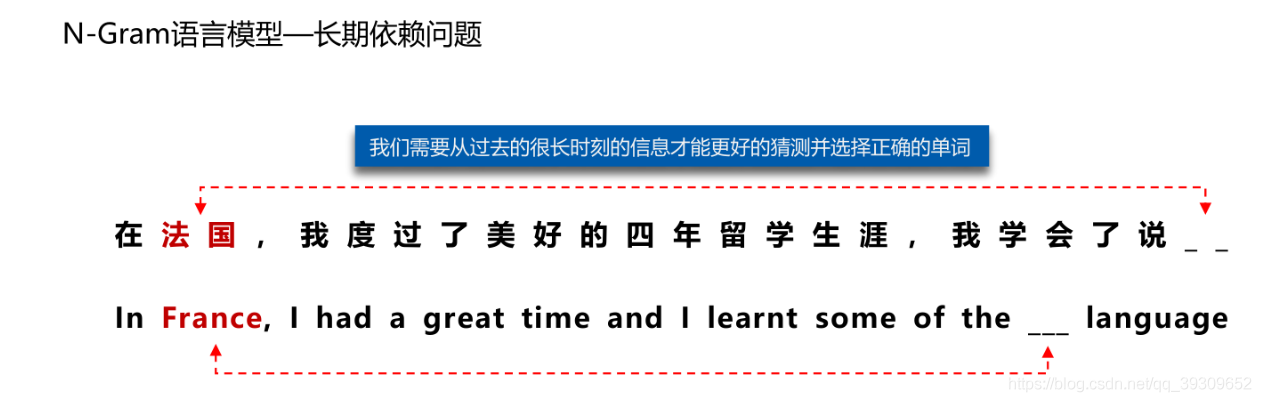

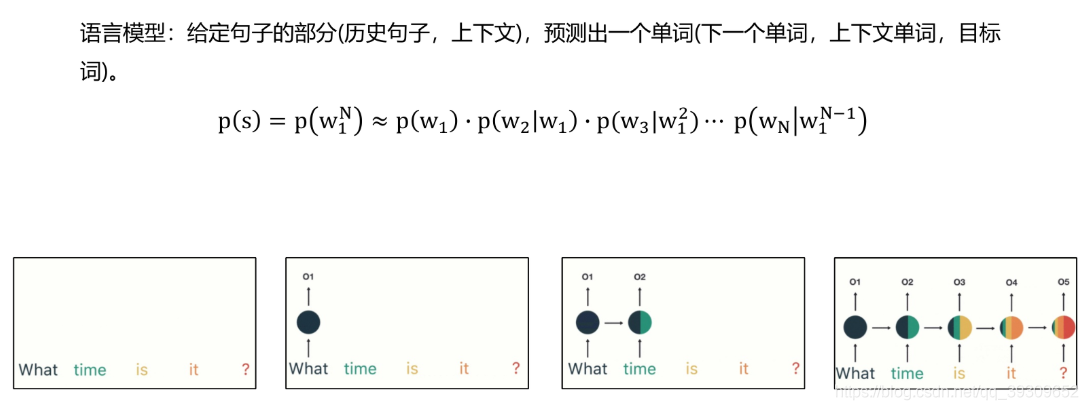

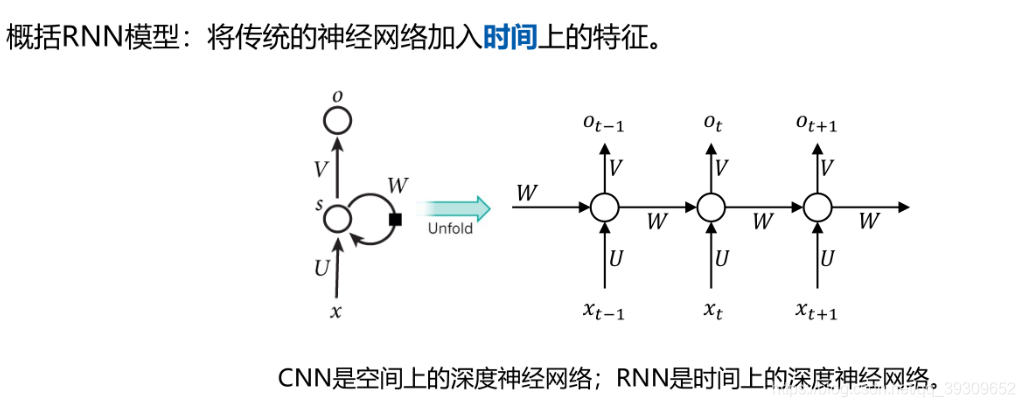

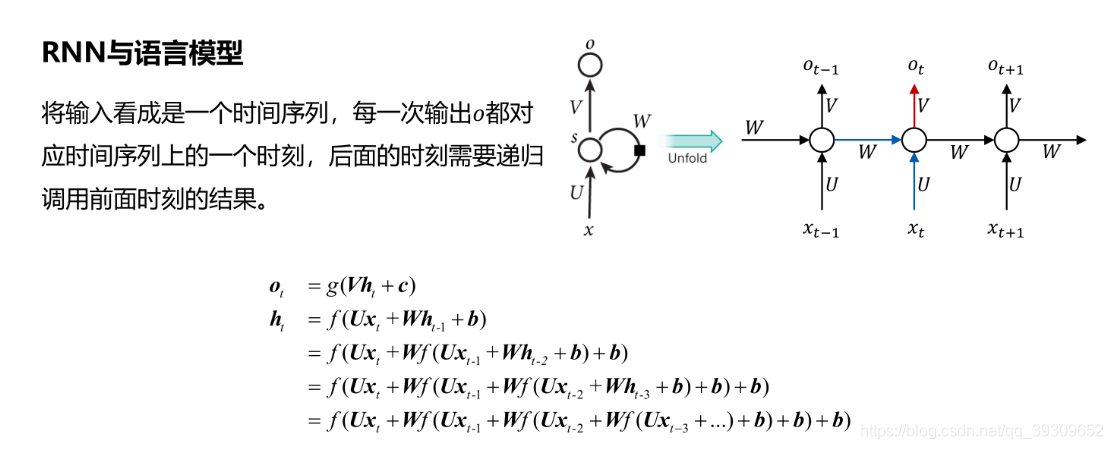

# pytorch 实现词性判别

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

In [2]:
#定义训练数据
training_data = [
    ("The cat ate the fish".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("They read that book".split(), ["NN", "V", "DET", "NN"])
]
#定义测试数据
testing_data=[("They ate the fish".split())]

In [3]:
testing_data

[['They', 'ate', 'the', 'fish']]

In [4]:
word_to_ix = {} # 单词的索引字典
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
print(word_to_ix)

{'The': 0, 'cat': 1, 'ate': 2, 'the': 3, 'fish': 4, 'They': 5, 'read': 6, 'that': 7, 'book': 8}


In [5]:
tag_to_ix = {"DET": 0, "NN": 1,'V':2} # 手工设定词性标签数据字典

# 构建网络

In [6]:
class LSTMTagger(nn.Module):
 
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
 
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
 
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
 
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden = self.init_hidden()
 
    #初始化隐含状态State及C
    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_dim),
                torch.zeros(1, 1, self.hidden_dim))
 
    def forward(self, sentence):
        #获得词嵌入矩阵embeds
        embeds = self.word_embeddings(sentence)   
        #按lstm格式，修改embeds的形状
        lstm_out, self.hidden = self.lstm(embeds.view(len(sentence), 1, -1), self.hidden)
        #修改隐含状态的形状，作为全连接层的输入
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        #计算每个单词属于各词性的概率
        tag_scores = F.log_softmax(tag_space,dim=1)
        return tag_scores


In [7]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    tensor = torch.LongTensor(idxs)
    return tensor

In [8]:
len(tag_to_ix)

3

In [9]:
EMBEDDING_DIM=10
HIDDEN_DIM=3  #这里等于词性个数

model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [10]:
inputs = prepare_sequence(training_data[0][0], word_to_ix)
tag_scores = model(inputs)
print(training_data[0][0])
print(inputs)
print(tag_scores)
print(torch.max(tag_scores,1))

['The', 'cat', 'ate', 'the', 'fish']
tensor([0, 1, 2, 3, 4])
tensor([[-1.3486, -1.3209, -0.7476],
        [-1.3394, -1.3782, -0.7216],
        [-1.2578, -1.4399, -0.7365],
        [-1.1332, -1.5226, -0.7768],
        [-1.1411, -1.4340, -0.8161]], grad_fn=<LogSoftmaxBackward>)
torch.return_types.max(
values=tensor([-0.7476, -0.7216, -0.7365, -0.7768, -0.8161], grad_fn=<MaxBackward0>),
indices=tensor([2, 2, 2, 2, 2]))


In [12]:
for epoch in range(4): # 我们要训练400次。
    for sentence, tags in training_data:
# 清除网络先前的梯度值
        model.zero_grad()
# 重新初始化隐藏层数据
        model.hidden = model.init_hidden()
# 按网络要求的格式处理输入数据和真实标签数据
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)
# 实例化模型
        tag_scores = model(sentence_in)
# 计算损失，反向传递梯度及更新模型参数
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
 
# 查看模型训练的结果
inputs = prepare_sequence(training_data[0][0], word_to_ix)
tag_scores = model(inputs)
print(training_data[0][0])
print(tag_scores)
print(torch.max(tag_scores,1))

['The', 'cat', 'ate', 'the', 'fish']
tensor([[-1.2815, -1.1403, -0.9097],
        [-1.2733, -1.1529, -0.9054],
        [-1.1950, -1.2234, -0.9087],
        [-1.0726, -1.3143, -0.9436],
        [-1.0995, -1.2343, -0.9784]], grad_fn=<LogSoftmaxBackward>)
torch.return_types.max(
values=tensor([-0.9097, -0.9054, -0.9087, -0.9436, -0.9784], grad_fn=<MaxBackward0>),
indices=tensor([2, 2, 2, 2, 2]))


In [13]:
test_inputs = prepare_sequence(testing_data[0], word_to_ix)
tag_scores01 = model(test_inputs)
print(testing_data[0])
print(test_inputs)
print(tag_scores01)
print(torch.max(tag_scores01,1))

['They', 'ate', 'the', 'fish']
tensor([5, 2, 3, 4])
tensor([[-1.1939, -1.1039, -1.0068],
        [-1.1869, -1.1438, -0.9775],
        [-1.0652, -1.2698, -0.9823],
        [-1.0978, -1.2158, -0.9944]], grad_fn=<LogSoftmaxBackward>)
torch.return_types.max(
values=tensor([-1.0068, -0.9775, -0.9823, -0.9944], grad_fn=<MaxBackward0>),
indices=tensor([2, 2, 2, 2]))


# RNN 实现预测一句话的下一个词

In [14]:
'''
  code by Tae Hwan Jung(Jeff Jung) @graykode, modify by wmathor
'''
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

dtype = torch.FloatTensor

sentences = [ "i like dog", "i love coffee", "i hate milk"]

word_list = " ".join(sentences).split()
vocab = list(set(word_list))
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for i, w in enumerate(vocab)}
n_class = len(vocab)

# TextRNN Parameter
batch_size = 2
n_step = 2 # number of cells(= number of Step)
n_hidden = 5 # number of hidden units in one cell

def make_data(sentences):
    input_batch = []
    target_batch = []

    for sen in sentences:
        word = sen.split()
        input = [word2idx[n] for n in word[:-1]]
        target = word2idx[word[-1]]

        input_batch.append(np.eye(n_class)[input])
        target_batch.append(target)

    return input_batch, target_batch

input_batch, target_batch = make_data(sentences)
input_batch, target_batch = torch.Tensor(input_batch), torch.LongTensor(target_batch)
dataset = Data.TensorDataset(input_batch, target_batch)
loader = Data.DataLoader(dataset, batch_size, True)

class TextRNN(nn.Module):
    def __init__(self):
        super(TextRNN, self).__init__()
        self.rnn = nn.RNN(input_size=n_class, hidden_size=n_hidden)
        # fc
        self.fc = nn.Linear(n_hidden, n_class)

    def forward(self, hidden, X):
        # X: [batch_size, n_step, n_class]
        X = X.transpose(0, 1) # X : [n_step, batch_size, n_class]
        out, hidden = self.rnn(X, hidden)
        # out : [n_step, batch_size, num_directions(=1) * n_hidden]
        # hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        out = out[-1] # [batch_size, num_directions(=1) * n_hidden] ⭐
        model = self.fc(out)
        return model

model = TextRNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
for epoch in range(500):
    for x, y in loader:
      # hidden : [num_layers * num_directions, batch, hidden_size]
      hidden = torch.zeros(1, x.shape[0], n_hidden)
      # x : [batch_size, n_step, n_class]
      pred = model(hidden, x)

      # pred : [batch_size, n_class], y : [batch_size] (LongTensor, not one-hot)
      loss = criterion(pred, y)
      if (epoch + 1) % 100 == 0:
          print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  
input = [sen.split()[:2] for sen in sentences]
# Predict
hidden = torch.zeros(1, len(input), n_hidden)
predict = model(hidden, input_batch).data.max(1, keepdim=True)[1]
print([sen.split()[:2] for sen in sentences], '->', [idx2word[n.item()] for n in predict.squeeze()])


Epoch: 0100 cost = 1.340223
Epoch: 0100 cost = 0.977303
Epoch: 0200 cost = 0.933199
Epoch: 0200 cost = 0.803330
Epoch: 0300 cost = 0.578840
Epoch: 0300 cost = 0.755750
Epoch: 0400 cost = 0.440023
Epoch: 0400 cost = 0.447675
Epoch: 0500 cost = 0.298266
Epoch: 0500 cost = 0.306650
[['i', 'like'], ['i', 'love'], ['i', 'hate']] -> ['dog', 'coffee', 'milk']
